In [1]:
import nltk
import pandas as pd
import numpy as np

ratings_data = pd.read_csv('./cleaned_data/cleaned_ratings.csv')

In [3]:
review_scores_distribution = ratings_data['review_score'].value_counts()
print(review_scores_distribution)
review_scores_distribution_percentages = (review_scores_distribution / len(ratings_data)) * 100
print(review_scores_distribution_percentages)



review_score
5.0    1807343
4.0     585616
3.0     254295
1.0     201688
2.0     151058
Name: count, dtype: int64
review_score
5.0    60.244767
4.0    19.520533
3.0     8.476500
1.0     6.722933
2.0     5.035267
Name: count, dtype: float64


In [2]:
# adapted from https://monkeylearn.com/blog/text-cleaning/
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm
tqdm.pandas()

sub = r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

stopwords = stopwords.words('english')



def clean_text(sentence):
    #lowercase
    sentence = str(sentence)
    sentence = sentence.lower()
    
    #remove weird characters
    sentence = re.sub(sub, "",sentence)
 
    #remove stopwords
    sentence = " ".join([word for word in sentence.split() if word not in (stopwords)])
    
    #stem words -> Try if a failure
    #sentence = " ".join([stemmer.stem(word) for word in sentence.split(" ")])
    return sentence

ratings_data['cleaned_text'] = ratings_data['text'].progress_apply(clean_text)
ratings_data['cleaned_text']



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alxto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 3000000/3000000 [19:00<00:00, 2629.82it/s]


0          julie strain fans collection photos 80 pages w...
1          dont care much dr seuss reading philip nels bo...
2          people become books read child father man dr s...
3          theodore seuss geisel 19041991 aka quotdr seus...
4          philip nel dr seuss american iconthis basicall...
                                 ...                        
2999995    extremely difficult book digest casual readers...
2999996    pretty interesting collingwood seems like firs...
2999997    good book esoteric history eh carr easier sele...
2999998    daughter freshman indiana university emailed l...
2999999    guy good ideas reader beware transciption seve...
Name: cleaned_text, Length: 3000000, dtype: object

In [3]:
from nltk.sentiment import SentimentIntensityAnalyzer
import tqdm
#get compound sentiment score between -1 and 1

sia = SentimentIntensityAnalyzer()


ratings_data['sentiment_score'] = ratings_data['cleaned_text'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])

print(ratings_data)


100%|██████████| 3000000/3000000 [57:57<00:00, 862.72it/s]  

                                  title  price review_helpfulness  \
0        Its Only Art If Its Well Hung!    NaN                7/7   
1              Dr. Seuss: American Icon    NaN              10/10   
2              Dr. Seuss: American Icon    NaN              10/11   
3              Dr. Seuss: American Icon    NaN                7/7   
4              Dr. Seuss: American Icon    NaN                3/3   
...                                 ...    ...                ...   
2999995             The Idea of History    NaN              14/19   
2999996             The Idea of History    NaN                1/1   
2999997             The Idea of History    NaN                0/0   
2999998             The Idea of History    NaN               1/11   
2999999             The Idea of History    NaN               7/49   

         review_score                                            summary  \
0                 4.0             Nice collection of Julie Strain images   
1                 5

In [4]:
from sklearn.linear_model import LinearRegression
# Create a linear regression between sentiment and review score

regression_model = LinearRegression()

X = ratings_data['sentiment_score'].values.reshape(-1, 1)
y = ratings_data['review_score'].values

regression_model.fit(X, y)


predicted_scores = regression_model.predict(X)


print(predicted_scores)


[4.41851158 4.43231656 4.448568   ... 4.27288939 3.87050615 3.91547428]


In [5]:
r_squared = regression_model.score(X, y)
print(r_squared)


0.06987527452673392


c:\Users\alxto\anaconda3\envs\nlp\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


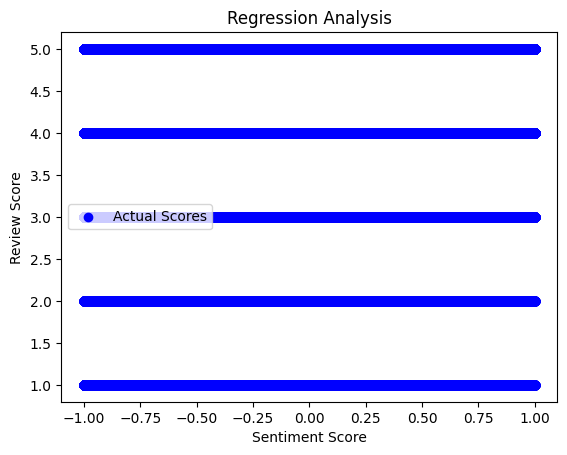

In [6]:
import matplotlib.pyplot as plt
#regression analysis (not super helpful with 3 million data points!)

plt.scatter(X, y, label='Actual Scores')

plt.xlabel('Sentiment Score')
plt.ylabel('Review Score')
plt.title('Regression Analysis')
plt.legend()
plt.show()


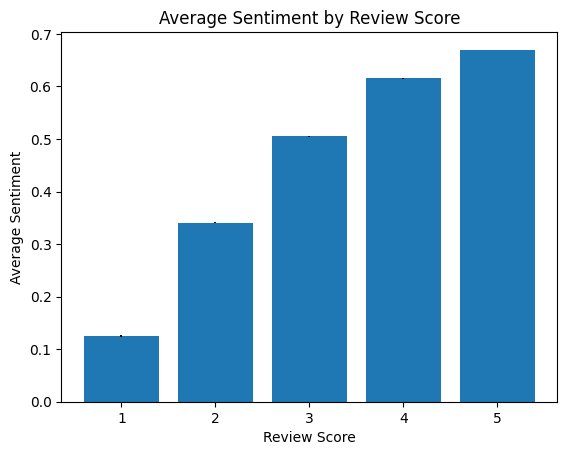

In [7]:
import matplotlib.pyplot as plt

# graph average review score by sentiment score
average_sentiment = ratings_data.groupby('review_score')['sentiment_score'].mean()


standard_error = ratings_data.groupby('review_score')['sentiment_score'].sem()


plt.bar(average_sentiment.index, average_sentiment, yerr=standard_error)

plt.xlabel('Review Score')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Review Score')
plt.show()


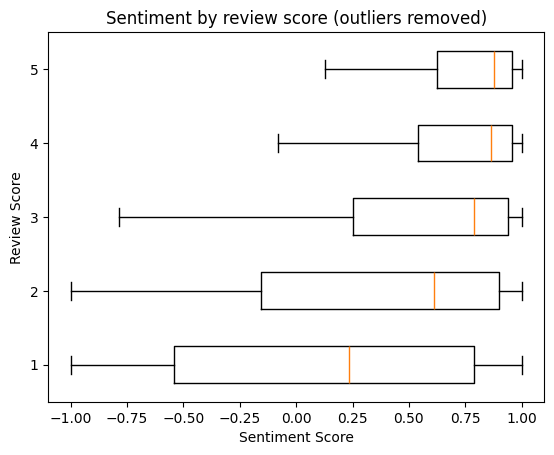

In [12]:
plt.boxplot(ratings_data.groupby('review_score')['sentiment_score'].apply(list), vert=False, showfliers=False)
plt.xlabel('Sentiment Score')
plt.ylabel('Review Score')
plt.title('Sentiment by review score (outliers removed)')
plt.show()


In [15]:
from scipy import stats


result = stats.f_oneway(ratings_data['review_score'], ratings_data['sentiment_score'])

# effect size calculation
n_groups = 5  
n_total = len(ratings_data) 

ss_between = result.statistic * (n_total - n_groups) / (n_groups - 1)
ss_total = ss_between + result.statistic
eta_squared = ss_between / ss_total

print("Eta-squared:", eta_squared)
print("F-statistic:", result.statistic)
print("p-value:", result.pvalue)


Effect Size (eta-squared): 0.9999986666662223
ANOVA Test Result:
F-statistic: 22565806.06879714
p-value: 0.0
